In [ ]:
!pip install pillow msgpack matplotlib

In [ ]:
import msgpack
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

shard_fnames = [
    "data/shard_0.msg",
    "data/shard_100.msg"
]

In [ ]:
def get_image(record):
        return Image.open(BytesIO(record["image"]))

In [ ]:
#images = []
metadata = []


for shard_fname in shard_fnames[0:]:
    with open(shard_fname, "rb") as infile:
        for record in msgpack.Unpacker(infile, raw=False):
            #images.append(get_image(record))
            record.pop("image")
            metadata.append(record)

len(images)

59999

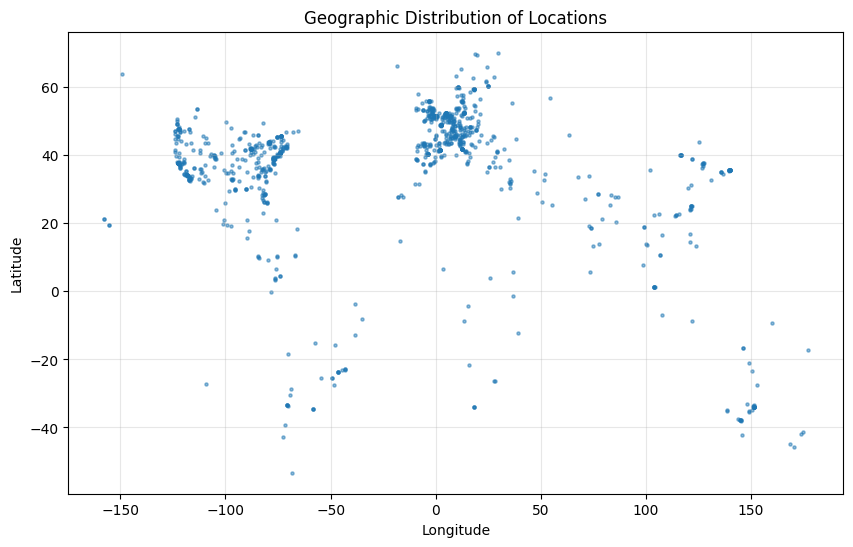

Plotted 59999 locations


In [ ]:
# Extract latitudes and longitudes for plotting
latitudes = [loc["latitude"] for loc in metadata[:1000]]
longitudes = [loc["longitude"] for loc in metadata[:1000]]

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(longitudes, latitudes, alpha=0.5, s=5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution of Locations')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Plotted {len(locations)} locations")

In [ ]:

for shard_fname in shard_fnames[0:]:
    with open(shard_fname, "rb") as infile:
        for record in msgpack.Unpacker(infile, raw=False):
            record.pop('image')
            print(record)
            break
    break

{'id': 'ba/08/6468190417.jpg', 'latitude': 41.906, 'longitude': 12.455}


In [ ]:
! pip install git+https://github.com/openai/clip

In [ ]:
import clip
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [ ]:
input_image = [preprocess(images[i]) for i in range(10000)]

with torch.no_grad():
  image_embeddings = model.encode_image(torch.stack(input_image))
image_embeddings

tensor([[-0.2632, -0.3331, -0.0695,  ...,  0.1617,  0.4095,  0.0170],
        [-0.3672,  0.0145, -0.2076,  ...,  0.1935,  0.1111, -0.3373],
        [-0.7444, -0.0090, -0.2212,  ...,  0.6025, -0.1964,  0.1293],
        ...,
        [ 0.4669,  0.0948,  0.1414,  ...,  0.5144,  0.0119,  0.4428],
        [-0.0144, -0.1957,  0.4262,  ...,  1.0591,  0.2209, -0.2196],
        [-0.3334,  0.0762, -0.2925,  ...,  0.4376,  0.4702,  0.0027]])

In [ ]:
import numpy as np

np.shape(image_embeddings)

torch.Size([10000, 512])

In [ ]:
!pip install pinecone

In [ ]:
vectors = [{"id": metadata[i]["id"], "values": np.asarray(image_embeddings[i]), "metadata": {"latitude": metadata[i]["latitude"], "longitude": metadata[i]["longitude"]}} for i in range(10000)]


In [ ]:
from pinecone import Pinecone

pc = Pinecone(api_key="pcsk_jVJrn_JQ9p3o3YcitjbvszEbvkrE9vHF3z1BWGczM6rLzbfB6FcRoygm5X7aYAzjDg5is")
index = pc.Index("htv2025")

In [ ]:
batch_size = 500

for i in range(1000, 10000, 500):
    index.upsert(vectors[i:i+500])
    print("done", i)

In [ ]:
test_img = Image.open("img2.webp")
stream = BytesIO()
test_img.save(stream, "PNG")
test_img2 = Image.open(stream)

In [ ]:
with torch.no_grad():
  test_image_embeddings = model.encode_image(torch.stack([preprocess(test_img2)]))

In [ ]:
index.query(
    vector=test_image_embeddings.numpy().tolist(),
    top_k=3,
    include_values=False
)

In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json when prompted

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
dataset_dir = "/kaggle/input/large-dataset-of-geotagged-images/shards/"
shard_names = [f"shard_{i}.msg" for i in range(0, 50)]
shard_fnames = [dataset_dir + f"shard_{i}.msg" for i in range(0, 50)]

In [ ]:
import kagglehub

# Download latest version
for name in shard_names:
  path = kagglehub.dataset_download("habedi/large-dataset-of-geotagged-images", path=f"shards/{name}")
  print("Path to dataset files:", path)

In [ ]:
def process_shard(shard_name: str):
  images = []
  metadata = []

  with open(shard_name, "rb") as infile:
      for record in msgpack.Unpacker(infile, raw=False):
          images.append(get_image(record))
          record.pop("image")
          metadata.append(record)

  input_image = []

  for i in range(10000):
    input_image.append(preprocess(images[i]))
    if i%1000 == 0:
      print("done", i)

  print("starting encoding")
  with torch.no_grad():
    image_embeddings = model.encode_image(torch.stack(input_image))
  print("done encoding")
  vectors = [{"id": metadata[i]["id"], "values": np.asarray(image_embeddings[i]), "metadata": {"latitude": metadata[i]["latitude"], "longitude": metadata[i]["longitude"]}} for i in range(len(metadata))]
  batch_size = 500

  for i in range(0, len(metadata), 1000):
      index.upsert(vectors[i:min(len(metadata), i+1000)], namespace=)
      print("done upserting", i)

  print("finished processing", shard_name)
